In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/data')
!pwd

/content/drive/My Drive/data


[github原始地址](https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/pix2pix/pix2pix_eager.ipynb)

该笔记本使用条件GAN演示图像到图像的转换，如使用条件对抗网络的图像到图像转换中所述。 使用这种技术，我们可以着色黑白照片，将谷歌地图转换为谷歌地球等。在这里，我们将建筑物外墙转换为真实建筑物。 我们使用tf.keras和eager执行来实现这一目标。

例如，我们将使用CMP Facade数据库，由布拉格捷克技术大学机器感知中心提供。 为了简化我们的示例，我们将使用由上述论文的作者创建的该数据集的预处理副本。

单个P100 GPU上的每个纪元大约需要58秒。

以下是训练200个时期模型后生成的输出

---
![图片](https://camo.githubusercontent.com/623ba268ffd0bd96c11e820a3117c229da0a7d49/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f67616e2f706978327069785f312e706e67)
![图片](https://camo.githubusercontent.com/7ae12e1b410322152c3f902397de2bc88e474a69/68747470733a2f2f7777772e74656e736f72666c6f772e6f72672f696d616765732f67616e2f706978327069785f322e706e67)

##Import TensorFlow and enable eager execution

In [0]:
#Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output

##加载数据集
您可以从此处[下载此数据集](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets)和类似数据集。 如[论文](https://arxiv.org/abs/1611.07004)所述，我们将随机抖动和镜像应用于训练数据集。

- 在随机抖动中，图像大小调整为286 x 286，然后随机裁剪为256 x 256
- 在随机镜像中，图像随机地水平翻转，即从左到右。

In [0]:
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                     cache_subdir=os.path.abspath('.'),
                                     origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz',
                                     extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'facades')

In [6]:
PATH = os.path.join('.','facades')
BUFFER_SIZE=400
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256
PATH

'./facades'

In [0]:
def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  w = tf.shape(image)[1]
  
  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]
  
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)
  
  if is_train:
    #random jittering
    
    #resizing to 286 x 286 x 3
    input_image = tf.image.resize_images(input_image, [286,286],
                                        align_corners=True,
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286,286],
                                       align_corners=True,
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    #randomly cropping to 256 x 256 x 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2,IMG_HEIGHT, IMG_WIDTH,3])
    input_image, real_image = cropped_image[0], cropped_image[1]
    
    if np.random.random() > 0.5:
      # random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT,IMG_WIDTH],
                                        align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT,IMG_WIDTH],
                                       align_corners=True, method=2)
    
  # normalizing the images to [-1,1]
  input_image = (input_image /127.5) -1
  real_image = (real_image / 127.5) -1
  
  return input_image, real_image

    

###Use tf.data to create batches, map(do preprocessing) and shuffle the dataset

In [0]:
train_dataset = tf.data.Dataset.list_files(PATH + '/train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(1)

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+'/test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(1)

##编写生成器和鉴别器模型

- 生成器

  - 生成器的架构是改进的U-Net。
  - 编码器中的每个块都是（Conv  - > Batchnorm  - > Leaky ReLU）
  - 解码器中的每个块是（Transposed Conv  - > Batchnorm  - > Dropout（应用于前3个块） - > ReLU）
  - 编码器和解码器之间存在跳过连接（如在U-Net中）。
- 鉴别

- 鉴别器是PatchGAN。
  - 鉴别器中的每个块都是（Conv  - > BatchNorm  - > Leaky ReLU）
  - 最后一层之后的输出形状为（batch_size，30,30,1）
  - 输出的每个30x30补丁分类输入图像的70x70部分（这种架构称为PatchGAN）。
  - 鉴别器接收2个输入。
    - 输入图像和目标图像，它应该归类为真实的。
    - 输入图像和生成的图像（生成器的输出），它应该归类为伪造的。
    - 我们在代码中将这两个输入连接在一起（`tf.concat（[inp，tar]，axis = -1）`）
    - 通过发生器和鉴别器的输入的形状在代码中的注释中。

要了解有关体系结构和超参数的更多信息，请[参阅本论文](https://arxiv.org/abs/1611.07004)。

In [0]:
OUTPUT_CHANNELS = 3

In [11]:
class Downsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(Downsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 


class Upsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_dropout=False):
    super(Upsample, self).__init__()
    self.apply_dropout = apply_dropout
    initializer = tf.random_normal_initializer(0., 0.02)

    self.up_conv = tf.keras.layers.Conv2DTranspose(filters, 
                                                   (size, size), 
                                                   strides=2, 
                                                   padding='same',
                                                   kernel_initializer=initializer,
                                                   use_bias=False)
    self.batchnorm = tf.keras.layers.BatchNormalization()
    if self.apply_dropout:
        self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, x1, x2, training):
    x = self.up_conv(x1)
    x = self.batchnorm(x, training=training)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = tf.nn.relu(x)
    x = tf.concat([x, x2], axis=-1)
    return x


class Generator(tf.keras.Model):
    
  def __init__(self):
    super(Generator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = Downsample(64, 4, apply_batchnorm=False)
    self.down2 = Downsample(128, 4)
    self.down3 = Downsample(256, 4)
    self.down4 = Downsample(512, 4)
    self.down5 = Downsample(512, 4)
    self.down6 = Downsample(512, 4)
    self.down7 = Downsample(512, 4)
    self.down8 = Downsample(512, 4)

    self.up1 = Upsample(512, 4, apply_dropout=True)
    self.up2 = Upsample(512, 4, apply_dropout=True)
    self.up3 = Upsample(512, 4, apply_dropout=True)
    self.up4 = Upsample(512, 4)
    self.up5 = Upsample(256, 4)
    self.up6 = Upsample(128, 4)
    self.up7 = Upsample(64, 4)

    self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                (4, 4), 
                                                strides=2, 
                                                padding='same',
                                                kernel_initializer=initializer)
  
  @tf.contrib.eager.defun
  def call(self, x, training):
    # x shape == (bs, 256, 256, 3)    
    x1 = self.down1(x, training=training) # (bs, 128, 128, 64)
    x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
    x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
    x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
    x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
    x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
    x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
    x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

    x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
    x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
    x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
    x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
    x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
    x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
    x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

    x16 = self.last(x15) # (bs, 256, 256, 3)
    x16 = tf.nn.tanh(x16)

    return x16

W0906 01:25:50.859738 139717701089152 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
class DiscDownsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(DiscDownsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 

class Discriminator(tf.keras.Model):
    
  def __init__(self):
    super(Discriminator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = DiscDownsample(64, 4, False)
    self.down2 = DiscDownsample(128, 4)
    self.down3 = DiscDownsample(256, 4)
    
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
    self.conv = tf.keras.layers.Conv2D(512, 
                                       (4, 4), 
                                       strides=1, 
                                       kernel_initializer=initializer, 
                                       use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
    self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
    self.last = tf.keras.layers.Conv2D(1, 
                                       (4, 4), 
                                       strides=1,
                                       kernel_initializer=initializer)
  
  @tf.contrib.eager.defun
  def call(self, inp, tar, training):
    # concatenating the input and the target
    x = tf.concat([inp, tar], axis=-1) # (bs, 256, 256, channels*2)
    x = self.down1(x, training=training) # (bs, 128, 128, 64)
    x = self.down2(x, training=training) # (bs, 64, 64, 128)
    x = self.down3(x, training=training) # (bs, 32, 32, 256)

    x = self.zero_pad1(x) # (bs, 34, 34, 256)
    x = self.conv(x)      # (bs, 31, 31, 512)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.leaky_relu(x)
    
    x = self.zero_pad2(x) # (bs, 33, 33, 512)
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    x = self.last(x)      # (bs, 30, 30, 1)

    return x

In [0]:
# The call function of Generator and Discriminator have been decorated
# with tf.contrib.eager.defun()
# We get a performance speedup if defun is used (~25 seconds per epoch)
generator = Generator()
discriminator = Discriminator()

##定义损失函数和优化程序

- 判别者损失

  - 鉴别器丢失功能需要2个输入; 真实图像，生成图像
  - real_loss是真实图像的sigmoid交叉熵损失和一个数组（因为这些是真实的图像）
  - generated_loss是生成的图像的sigmoid交叉熵丢失和零的数组（因为这些是伪图像）
  - 然后total_loss是real_loss和generated_loss的总和
- 生成器损耗

  - 它是生成的图像的sigmoid交叉熵损失和一组数组。
  - 该论文还包括L1损失，其是生成的图像和目标图像之间的MAE（平均绝对误差）。
  - 这允许生成的图像在结构上变得类似于目标图像。
  - 计算总发电机损耗的公式= gan_loss + LAMBDA * l1_loss，其中LAMBDA = 100.该值由本文作者决定。

In [0]:
LAMBDA = 100

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output), 
                                              logits = disc_real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output), 
                                                   logits = disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output) 
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)

##Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

##训练
- 我们首先迭代数据集
- 生成器获取输入图像，我们得到生成的输出。
- 鉴别器接收input_image和生成的图像作为第一输入。 第二个输入是input_image和target_image。
- 接下来，我们计算发电机和鉴别器损耗。
- 然后，我们计算相对于发生器和鉴别器变量（输入）的损耗梯度，并将它们应用于优化器。
##生成图像
- 经过培训，它有时间生成一些图像！
- 我们将图像从测试数据集传递到生成器。
- 然后，生成器将输入图像转换为我们期望的输出。
- 最后一步是绘制预测和瞧！

In [0]:
EPOCHS = 200

In [0]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [0]:
def train(dataset, epochs):  
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(input_image, target, training=True)
        disc_generated_output = discriminator(input_image, gen_output, training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

      generator_gradients = gen_tape.gradient(gen_loss, 
                                              generator.variables)
      discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                   discriminator.variables)

      generator_optimizer.apply_gradients(zip(generator_gradients, 
                                              generator.variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                  discriminator.variables))

    if epoch % 1 == 0:
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
          generate_images(generator, inp, tar)
          
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

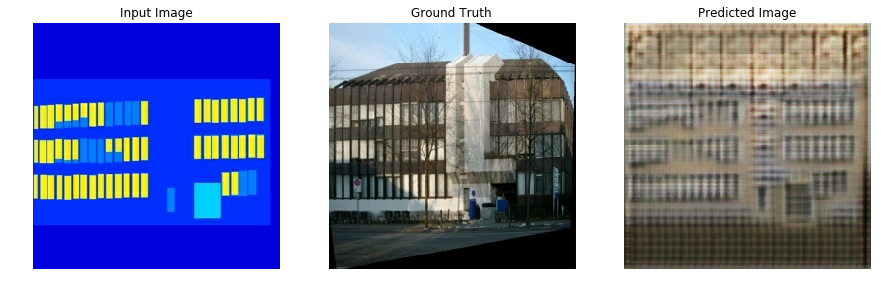

Time taken for epoch 3 is 126.22473096847534 sec



In [0]:
train(train_dataset, EPOCHS)

#Restore the latest checkpoint and test

In [1]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

NameError: ignored

##Testing on the entire test dataset

In [0]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
  generate_images(generator, inp, tar)